In [1]:
import sys, os, argparse, shutil, inspect

import numpy as np
import tensorflow as tf
from tensorflow import keras

import tf_datasets
# import tf_network

import logging, pickle

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
sys.argv = ['scenes/tf_train.py', '--mve', '-o', '/tmp/tfmodel/', '../training_data/Original/tdata/']

In [3]:
parser = argparse.ArgumentParser(description='Generate Training Data', formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('-o', '--output', default='/tmp/tfmodel/',   help='output directory')
parser.add_argument('-l', '--load',   action="store_true",       help='load and resume the training')
parser.add_argument(      '--lstep',  default=100,   type=int,   help='log summary; e.g., every 10th steps')
parser.add_argument('-s', '--steps',  default=10000, type=int,   help='maximum training steps')
parser.add_argument('-b', '--batch',  default=5000,  type=int,   help='batch size for one step training')
parser.add_argument('-t', '--ftest',  default=0.25,  type=float, help='fraction for the test data set')
parser.add_argument('-d', '--dnet',   default='27-34-2',         help='detection networks int-int-...')
parser.add_argument('-m', '--mnet',   default='27-34-2',         help='modification networks int-int-...')
parser.add_argument(      '--dact',   default='none-tanh-tanh',  help='activation function for detection networks')
parser.add_argument(      '--mact',   default='none-tanh-tanh',  help='activation function for modification networks')
parser.add_argument(      '--stats',  action="store_true",       help='write the stats')
parser.add_argument('-v', '--mve',    action="store_true",       help='turn on mean-variance learning')
parser.add_argument(      '--nosmax', action="store_true",       help='do not use the softmax model')
parser.add_argument('-r', '--decay',  default=0.1,   type=float, help='regularization coefficient')
parser.add_argument(      '--ddrop',  default=0.1,   type=float, help='dropout rate (detection)')
parser.add_argument(      '--mdrop',  default=0.1,   type=float, help='dropout rate (modification)')
parser.add_argument('datadirs', action="store", nargs="+",       help='path(s) to the training data')
pargs = parser.parse_args()

In [4]:
# pargs.dnet = "27-34-17-2"
# pargs.mnet = "27-34-17-2"
# pargs.dact = "none-tanh-tanh-tanh"
# pargs.mact = "none-tanh-tanh-tanh"

pargs.output = "models/SAM/"
pargs.dnet = "27-34-2"
pargs.mnet = "27-34-2"
pargs.dact = "none-tanh-tanh"
pargs.mact = "none-tanh-tanh"

In [5]:
pargs.output = os.path.normpath(pargs.output)
os.path.isdir(pargs.output) or os.makedirs(pargs.output)

shutil.copy(inspect.stack()[-1][1], pargs.output+'/')
with open(pargs.output+'/run_args.pickle', 'wb') as f: 
    pickle.dump(vars(pargs), f)
with open(pargs.output+'/run_cmd.txt', 'w') as f: 
    f.write(' '.join(os.uname()) + '\n' + ' '.join(sys.argv))

data_sets, N_tuple = tf_datasets.read_data_sets(dirs=sorted(pargs.datadirs), use_softmax=(not pargs.nosmax), frac_test=pargs.ftest)
scale = { i: max(abs(data_sets.train.get_data()[i].min()), abs(data_sets.train.get_data()[i].max())) for i in data_sets.train.get_data() }
with open(pargs.output+'/scale.pickle', 'wb') as f: 
    pickle.dump(scale, f)

logging.basicConfig(filename='{}/training-info.log'.format(pargs.output), level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler())
logging.info('tensorflow-{} ({}, {})'.format(tf.__version__, tf.sysconfig.get_include(), tf.sysconfig.get_lib()))
logging.info(pargs)
logging.info('{} tuples have been loaded; randomly selected {} for the training set and {} for the test set'.format(
    N_tuple, data_sets.train._num_examples, data_sets.test._num_examples))
logging.info(scale)

tensorflow-2.5.0 (/usr/local/lib/python3.8/dist-packages/tensorflow/include, /usr/local/lib/python3.8/dist-packages/tensorflow)
Namespace(batch=5000, dact='none-tanh-tanh', datadirs=['../training_data/Original/tdata/'], ddrop=0.1, decay=0.1, dnet='27-34-2', ftest=0.25, load=False, lstep=100, mact='none-tanh-tanh', mdrop=0.1, mnet='27-34-2', mve=True, nosmax=False, output='models/SAM', stats=False, steps=10000)
8376 tuples have been loaded; randomly selected 6282 for the training set and 2094 for the test set
{'inputs': 3.7656653, 'labels': 1.0, 'modvel': 2.749637}


In [6]:
# statistics
if pargs.stats and (not pargs.load):
    with PdfPages(pargs.output+'/histogram.pdf') as pdf, open(pargs.output+'/dataset_stats.pickle', 'wb') as log:
        l = data_sets.train.get_data()['labels']
        if not pargs.nosmax: l = l[:,0]
        dataset_stats = {}
        for i in sorted(data_sets.train.get_data()):
            d = data_sets.train.get_data()[i][(l==1).reshape(-1)] # only splash particles
            dataset_stats[i] = [None]*d.shape[1]
            for j in range(d.shape[1]):
                d_row = d[:,j].reshape(-1)
                dataset_stats[i][j] = { 'mean': np.mean(d_row), 'std': np.std(d_row), 'min': np.amin(d_row), 'max': np.amax(d_row) }
                plt.figure()
                plt.hist(d_row, bins='auto')
                plt.title('Histogram of {}[{}]'.format(i, j))
                plt.savefig(pdf, format='pdf')
                plt.close()

        pickle.dump(dataset_stats, log)

In [7]:
# tf.set_random_seed(1)
tf.random.set_seed(1)

def parse_act(act):
    if act == 'tanh':    return tf.nn.tanh
    if act == 'sigmoid': return tf.nn.sigmoid
    if act == 'relu':    return tf.nn.relu
    return tf.nn.tanh

In [8]:
# # init_weights = { 'w': {'mean': float, 'stddev': float}, 'b': {'value': float} }
# def weight_variable(shape, init_weights=None):
#     params = dict(shape=shape)
#     if init_weights and 'w' in init_weights: params.update(init_weights['w'])
#     initial = tf.truncated_normal(**params)
#     return tf.Variable(initial)

In [9]:
# def bias_variable(shape, init_weights=None):
#     params = dict(value=0.1, shape=shape)
#     if init_weights and 'b' in init_weights: params.update(init_weights['b'])
#     initial = tf.constant(**params)
#     return tf.Variable(initial)

In [10]:
# def variable_summaries(var, name):
#     """Attach a lot of summaries to a Tensor."""
#     with tf.name_scope('summaries'):
#         mean = tf.reduce_mean(var)
#         tf.summary.scalar(name='mean/' + name, tensor=mean)
#         with tf.name_scope('stddev'):
#             stddev = tf.sqrt(tf.reduce_sum(tf.square(var - mean)))

#         tf.summary.scalar(name='stddev/' + name, tensor=stddev)
#         tf.summary.scalar(name='max/' + name, tensor=tf.reduce_max(var))
#         tf.summary.scalar(name='min/' + name, tensor=tf.reduce_min(var))
#         tf.summary.histogram(name=name, values=var)

In [11]:
# def nn_layer(input_tensor, input_dim, output_dim, layer_name,
#              init_weights=None, drop=None, bn=False, is_training=True, act=tf.nn.tanh):
    
#     x = keras.layers.Dense(input_dim, activation=act)(input_tensor)    
#     if bn:
#         x = layers.BatchNormalization(momentum=0.99, #0.999 
#             epsilon=0.001, # 1e-4
#          )(x)
        
#     x = keras.layers.Dropout(drop)(x)
    
#     return x

In [12]:
# def build_network(layers, layers_act=None, input_x_holder=None, input_y_holder=None, dropout_holder=None,
#                   init_weights=None, bn=False, is_training=True, scope=''):
#     with tf.name_scope('{}input'.format(scope)):
#         x  =  input_x_holder
#         y_ = input_y_holder

#     lp = x

#     for i in range(1, len(layers)-1):
#         lp = nn_layer(input_tensor=lp, input_dim=layers[i-1], output_dim=layers[i], layer_name='{}layer{}'.format(scope, i),
#                       init_weights=init_weights, drop=dropout_holder, bn=bn, is_training=is_training,
#                       act=layers_act[i] if layers_act else tf.nn.tanh)

#     y = nn_layer(input_tensor=lp, input_dim=layers[i], output_dim=layers[i+1], layer_name='{}layer_full'.format(scope),
#                  init_weights=init_weights, drop=dropout_holder, bn=bn, is_training=is_training,
#                  act=layers_act[i+1] if layers_act else tf.nn.tanh)

#     return x, y_, y

In [13]:
# logging.info('Neural network structure: detection {} and modification {}'.format(pargs.dnet, pargs.mnet))
# dlayers    = list(map(int, pargs.dnet.split('-')))
# mlayers    = list(map(int, pargs.mnet.split('-')))
# dact       = list(map(tf_network.parse_act, pargs.dact.split('-')))
# mact       = list(map(tf_network.parse_act, pargs.mact.split('-')))
# init_w     = {'w': {'stddev': 0.1}, 'b': {'value': 0.5}}
# # x          = tf.placeholder(tf.float32, shape=[None, dlayers[0]], name='x-input')
# # keep_prob  = tf.placeholder(tf.float32, name='keep_prob_detector') if pargs.ddrop>0.0 else None
# # keep_prob2 = tf.placeholder(tf.float32, name='keep_prob_modifier') if pargs.mdrop>0.0 else None
# y_,  y     = tf_network.build_network(dlayers, dact, init_weights=init_w, input_x_holder=x, dropout_holder=keep_prob,  bn=True, scope='detector/')[1:]
# y2_, y2    = tf_network.build_network(mlayers, mact, init_weights=init_w, input_x_holder=x, dropout_holder=keep_prob2, bn=True, scope='modifier/')[1:]
# if pargs.mve:
#     s      = tf_network.build_network(mlayers, mact, init_weights=init_w, input_x_holder=x, input_y_holder=y2_, dropout_holder=keep_prob2, bn=True, scope='modifier_var/')[2]

# global_step = tf.Variable(0, trainable=False, name='global_step')

In [14]:
logging.info('Neural network structure: detection {} and modification {}'.format(pargs.dnet, pargs.mnet))
dlayers    = list(map(int, pargs.dnet.split('-')))
mlayers    = list(map(int, pargs.mnet.split('-')))
# dact       = list(map(tf_network.parse_act, pargs.dact.split('-')))
# mact       = list(map(tf_network.parse_act, pargs.mact.split('-')))
# init_w     = {'w': {'stddev': 0.1}, 'b': {'value': 0.5}}

Neural network structure: detection 27-34-2 and modification 27-34-2


In [15]:
# x = keras.Input(shape=(dlayers[0],))


# def build_network(layers, layers_act=None, input_x_holder=None, input_y_holder=None, dropout_holder=None,
#                   init_weights=None, bn=False, is_training=True, scope=''):
#     lp = x

#     for i in range(1, len(layers)-1):
#         lp = nn_layer(input_tensor=lp, input_dim=layers[i-1], output_dim=layers[i], layer_name='{}layer{}'.format(scope, i),
#                       init_weights=init_weights, keep_prob=dropout_holder, bn=bn, is_training=is_training,
#                       act=layers_act[i] if layers_act else tf.nn.tanh)

#     y = nn_layer(input_tensor=lp, input_dim=layers[i], output_dim=layers[i+1], layer_name='{}layer_full'.format(scope),
#                  init_weights=init_weights, keep_prob=dropout_holder, bn=bn, is_training=is_training,
#                  act=layers_act[i+1] if layers_act else tf.nn.tanh)

#     print(layers)

#     return x, y_, y


# y_,  y     = tf_network.build_network(dlayers, dact, init_weights=init_w, input_x_holder=x, dropout_holder=pargs.ddrop, bn=True, scope='detector/')[1:]
# y2_, y2    = tf_network.build_network(mlayers, mact, init_weights=init_w, input_x_holder=x, dropout_holder=pargs.mdrop, bn=True, scope='modifier/')[1:]

# if pargs.mve:
#     s      = tf_network.build_network(mlayers, mact, init_weights=init_w, input_x_holder=x, input_y_holder=y2_, dropout_holder=pargs.mdrop, bn=True, scope='modifier_var/')[2]


In [16]:
# ################################################################################
# # evaluation functions
# log_dict = {}
# with tf.name_scope('accuracy'):
#     with tf.name_scope('correct_prediction'):
#         if pargs.nosmax: corr, appx = tf.cast(tf.less(y_, 0.5), tf.int64), tf.cast(tf.less(y, 0.5), tf.int64) # f: splashing, t: non-splashing
#         else:            corr, appx = tf.argmax(y_, 1), tf.argmax(y, 1)                                       # 0: splashing, 1: non-splashing

#         correct_prediction = tf.equal(corr, appx)
#         accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#         y_b_appx           = tf.equal(appx, 0) # true: splashing, false: non-splashing
#         y_b_corr           = tf.equal(corr, 0)

#         N_corr_non_splas    = tf.reduce_sum(corr)
#         N_corr_splashing    = tf.cast(tf.shape(y_)[0], tf.int64) - N_corr_non_splas
#         diff_appx_corr      = tf.math.logical_xor(y_b_appx, y_b_corr)
#         N_corr_spl_appx_non = tf.reduce_sum(tf.cast(tf.logical_and(y_b_corr, diff_appx_corr), tf.float32))
#         N_corr_non_appx_spl = tf.reduce_sum(tf.cast(tf.logical_and(y_b_appx, diff_appx_corr), tf.float32))
#         false_negative      = N_corr_spl_appx_non/tf.cast(N_corr_splashing, tf.float32)
#         false_positive      = N_corr_non_appx_spl/tf.cast(N_corr_non_splas, tf.float32)

#         log_dict['accuracy']                     = accuracy
#         log_dict['false_negative_corr_T_appx_F'] = false_negative
#         log_dict['false_positive_corr_F_appx_T'] = false_positive
#         log_dict['splashes/corr']                = 1.0 - tf.reduce_mean(tf.cast(corr, tf.float32))
#         log_dict['splashes/appx']                = 1.0 - tf.reduce_mean(tf.cast(appx, tf.float32))

#     with tf.name_scope('loss'):
#         with tf.GradientTape() as tape:
#             loss_normalizer = 1.0/tf.cast(tf.shape(y2_)[0], tf.float32)

#             with tf.name_scope('detector'):
#                 if pargs.nosmax: loss_detector = tf.nn.l2_loss(y - y_)
#                 else:            loss_detector = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
#                 log_dict['detector/loss'] = loss_detector*loss_normalizer if pargs.nosmax else loss_detector

#             with tf.name_scope('modifier'):
#                 loss_modifier = tf.nn.l2_loss(y2 - y2_)
#                 log_dict['modifier/loss'] = loss_modifier*loss_normalizer
#                 if pargs.mve:
#                     loss_modifier_mve = 0.5*tf.reduce_sum(((y2 - y2_)**2)/(s**2 + 1e-9)) + 0.5*tf.reduce_sum(tf.math.log(s**2 + 1e-9)) # mean variance estimate
#                     log_dict['modifier_mve/loss'] = loss_modifier_mve*loss_normalizer

#             loss = loss_detector + loss_modifier
#             log_dict['sum_loss'] = log_dict['detector/loss'] + log_dict['modifier/loss']
#             if pargs.mve:
#                 loss_mve = loss_detector + loss_modifier_mve
#                 log_dict['sum_loss_mve'] = log_dict['detector/loss'] + log_dict['modifier_mve/loss']

#             if pargs.decay>0.0:
#                 w_detector     = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, "detector/")
#                 w_modifier     = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, "modifier/")
#                 decay_detector = tf.add_n([tf.nn.l2_loss(v) for v in w_detector])*pargs.decay
#                 decay_modifier = tf.add_n([tf.nn.l2_loss(v) for v in w_modifier])*pargs.decay

#                 loss += decay_detector + decay_modifier

#                 log_dict['detector/decay'] = decay_detector
#                 log_dict['modifier/decay'] = decay_modifier
#                 log_dict['sum_loss'] += decay_detector + decay_modifier

#                 if pargs.mve:
#                     w_modifier_var = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, "modifier_var/")
#                     decay_modifier_var = tf.add_n([tf.nn.l2_loss(v) for v in w_modifier_var])*pargs.decay
#                     loss_mve += decay_modifier_var
#                     log_dict['modifier_var/decay'] = decay_modifier_var
#                     log_dict['sum_loss_mve'] += decay_modifier_var

#     for i in log_dict:
#         tf.summary.scalar(name=i, data=log_dict[i])

In [17]:
# with tf.name_scope('train'):
#     opt = keras.optimizers.Adam(1e-4)
#     grads = tape.gradient(loss, [w_detector, w_modifier])
#     processed_grads = [process_gradient(g) for g in grads]
#     opt.apply_gradients(zip(processed_grads, [w_detector, w_modifier]))
    
# #     train_step = keras.optimizers.Adam(1e-4).minimize(loss, [w_detector, w_modifier])
    
#     if pargs.mve: 
#         opt_mve = keras.optimizers.Adam(1e-4)
#         grads_mve = tape.gradient(loss_mve, [w_modifier_var])
#         processed_grads_mve = [process_gradient(g) for g in grads_mve]
#         opt_mve.apply_gradients(zip(processed_grads_mve, [w_detector, w_modifier]))
        
# #         train_step_mve = keras.optimizers.Adam(1e-4).minimize(loss_mve, [w_modifier_var])

# increment_global_step = tf.assign_add(global_step, 1, name='increment_global_step')

In [18]:
def training_model():
    inputs = keras.layers.Input(dlayers[0],)
    
    y1 = keras.layers.Input(dlayers[-1],)
    y2 = keras.layers.Input(mlayers[-1],)
    
    x = inputs
    for i in range(1, len(dlayers)-1):
        x = keras.layers.Dense(dlayers[i], activation="tanh", 
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                              bias_initializer=tf.keras.initializers.Constant(0.5))(x)    
        if 1:
            x = keras.layers.BatchNormalization(momentum=0.999, #0.999 
                epsilon=0.0001, # 1e-4
             )(x)
        x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(dlayers[-1], activation="tanh", 
                          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                          bias_initializer=tf.keras.initializers.Constant(0.5))(x)
    x = keras.layers.BatchNormalization(momentum=0.999, #0.999 
                epsilon=0.0001, # 1e-4
             )(x)
    output1 = x
    
    x = inputs
    for i in range(1, len(mlayers)-1):
        x = keras.layers.Dense(mlayers[i], activation="tanh", 
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                              bias_initializer=tf.keras.initializers.Constant(0.5))(x)    
        if 1:
            x = keras.layers.BatchNormalization(momentum=0.999, #0.999 
                epsilon=0.0001, # 1e-4
             )(x)
        x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(mlayers[-1], activation="tanh", 
                          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                          bias_initializer=tf.keras.initializers.Constant(0.5))(x)
    x = keras.layers.BatchNormalization(momentum=0.999, #0.999 
                epsilon=0.0001, # 1e-4
             )(x)
    output2 = x
    
    x = inputs
    for i in range(1, len(mlayers)-1):
        x = keras.layers.Dense(mlayers[i], activation="tanh", 
                          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                          bias_initializer=tf.keras.initializers.Constant(0.5))(x)   
        if 1:
            x = keras.layers.BatchNormalization(momentum=0.999, #0.999 
                epsilon=0.0001, # 1e-4
             )(x)
        x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(mlayers[-1], activation="tanh", 
                          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                          bias_initializer=tf.keras.initializers.Constant(0.5))(x)
    x = keras.layers.BatchNormalization(momentum=0.999, #0.999 
                epsilon=0.0001, # 1e-4
             )(x)
    output3 = x
        
    model = keras.Model([inputs, y1, y2], [output1, output2, output3])
    return model, y1, y2, output1, output2, output3

In [19]:
# def training_model():
#     inputs = keras.layers.Input(dlayers[0],)
    
#     y1 = keras.layers.Input(dlayers[-1],)
#     y2 = keras.layers.Input(mlayers[-1],)
    
#     x = inputs
#     for i in range(1, len(dlayers)-1):
#         x = keras.layers.Dense(dlayers[i], activation="tanh")(x)    
#         if 1:
#             x = keras.layers.BatchNormalization(momentum=0.99, #0.999 
#                 epsilon=0.001, # 1e-4
#              )(x)
#         x = keras.layers.Dropout(0.1)(x)
#     x = keras.layers.Dense(dlayers[-1], activation="sigmoid")(x)
#     output1 = x
    
#     x = inputs
#     for i in range(1, len(mlayers)-1):
#         x = keras.layers.Dense(mlayers[i], activation="tanh")(x)    
#         if 1:
#             x = keras.layers.BatchNormalization(momentum=0.99, #0.999 
#                 epsilon=0.001, # 1e-4
#              )(x)
#         x = keras.layers.Dropout(0.1)(x)
#     x = keras.layers.Dense(mlayers[-1], activation="linear")(x)
#     output2 = x
    
#     x = inputs
#     for i in range(1, len(mlayers)-1):
#         x = keras.layers.Dense(mlayers[i], activation="tanh")(x)    
#         if 1:
#             x = keras.layers.BatchNormalization(momentum=0.99, #0.999 
#                 epsilon=0.001, # 1e-4
#              )(x)
#         x = keras.layers.Dropout(0.1)(x)
#     x = keras.layers.Dense(mlayers[-1], activation="linear")(x)
#     output3 = x
        
#     model = keras.Model([inputs, y1, y2], [output1, output2, output3])
#     return model, y1, y2, output1, output2, output3

In [20]:
def plot_history(history):
    plt.plot(history.history["loss"], label="Training Loss")
#     plt.plot(history.history["val_loss"], label="Validation Loss")
#     plt.plot(history.history["accuracy"], label="Training Accuracy")
#     plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.xscale('log')
#     plt.yscale('log')
    plt.grid()
    plt.savefig(pargs.output+"/loss.png", dpi=150)
    plt.show()

In [21]:
model_orig, y1, y2, out1, out2, out3 = training_model()

In [22]:
model_orig.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 34)           952         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 34)           952         input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 34)           952         input_1[0][0]                    
______________________________________________________________________________________________

In [23]:
# import tensorflow as tf
tf.config.run_functions_eagerly(False)

class SAMModel(tf.keras.Model):
    def __init__(self, model, rho=0.05, loss_stored=[]):
        """
        p, q = 2 for optimal results as suggested in the paper
        (Section 2)
        """
        super(SAMModel, self).__init__()
        self.model = model
        self.rho = rho
        self.loss_stored = loss_stored
        
    def call(self, data):
        return self.model(data)
#         with tf.GradientTape() as tape:
#             predictions = self.model(data)
#             loss = self.compiled_loss((data, predictions), predictions)
#         return loss

    def train_step(self, data):
        inputs = data
        (inp, y1, y2) = data[0]
        labels = y1
        e_ws = []
        with tf.GradientTape() as tape:
            predictions = self.model(data)
            [out1, out2, out3] = predictions 
            
            loss_detector = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y1, logits=out1))
            loss_modifier = tf.nn.l2_loss(out2 - y2)

            loss_modifier_mve = 0.5*tf.reduce_sum(((out2 - y2)**2)/(out3**2 + 1e-4)) + 0.5*tf.reduce_sum(tf.math.log(out3**2 + 1e-4)) # mean variance estimate

            loss = loss_detector + loss_modifier
            loss_mve = loss_detector + loss_modifier_mve
            loss = loss + loss_mve
        
        trainable_params = self.model.trainable_variables
        gradients = tape.gradient(loss, trainable_params)
        grad_norm = self._grad_norm(gradients)
        scale = self.rho / (grad_norm + 1e-12)

        for (grad, param) in zip(gradients, trainable_params):
            e_w = grad * scale
            param.assign_add(e_w)
            e_ws.append(e_w)

        with tf.GradientTape() as tape:
            predictions = self.model(data)
            [out1, out2, out3] = predictions 
            
            loss_detector = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y1, logits=out1))
            loss_modifier = tf.nn.l2_loss(out2 - y2)

            loss_modifier_mve = 0.5*tf.reduce_sum(((out2 - y2)**2)/(out3**2 + 1e-4)) + 0.5*tf.reduce_sum(tf.math.log(out3**2 + 1e-4)) # mean variance estimate

            loss = loss_detector + loss_modifier
            loss_mve = loss_detector + loss_modifier_mve
            loss = loss + loss_mve
            
            self.loss_stored.append(loss)
        
        sam_gradients = tape.gradient(loss, trainable_params)
        for (param, e_w) in zip(trainable_params, e_ws):
            param.assign_sub(e_w)
        
        self.optimizer.apply_gradients(
            zip(sam_gradients, trainable_params))
        
        self.compiled_metrics._metrics = loss
#         self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        (inp, y1, y2) = data[0]
        predictions = self.model(data, training=False)
        [out1, out2, out3] = predictions 
    
        loss_detector = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y1, logits=out1))
        loss_modifier = tf.nn.l2_loss(out2 - y2)

        loss_modifier_mve = 0.5*tf.reduce_sum(((out2 - y2)**2)/(out3**2 + 1e-4)) + 0.5*tf.reduce_sum(tf.math.log(out3**2 + 1e-4)) # mean variance estimate

        loss = loss_detector + loss_modifier
        loss_mve = loss_detector + loss_modifier_mve

        loss = loss + loss_mve
        
#         loss = self.compiled_loss(labels, predictions)
        self.compiled_metrics._metrics = loss
#         self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def _grad_norm(self, gradients):
        norm = tf.norm(
            tf.stack([
                tf.norm(grad) for grad in gradients if grad is not None
            ])
        )
        return norm

In [24]:
# model_orig([train_data["inputs"], train_data["labels"], train_data["modvel"]/scale["modvel"]])

In [25]:
model = SAMModel(model_orig)

In [26]:
# model([tensor1, tensor2, tensor3])

In [27]:
# model.compiled_loss([x, tf.keras.layers.Input(2), tf.keras.layers.Input(2)])

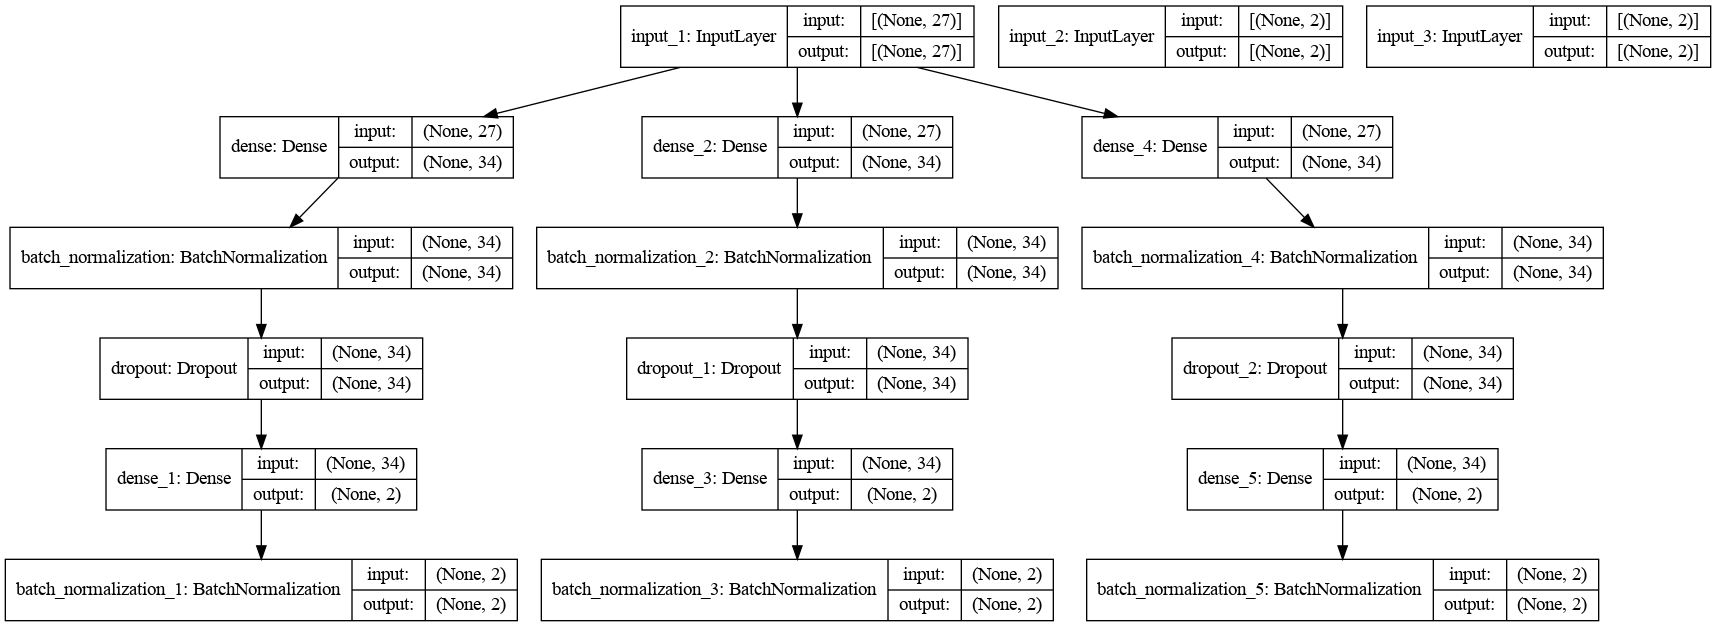

In [28]:
tf.keras.utils.plot_model(model_orig, show_shapes=True)

In [29]:
loss_detector = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y1, logits=out1))
loss_modifier = tf.nn.l2_loss(out2 - y2)

loss_modifier_mve = 0.5*tf.reduce_sum(((out2 - y2)**2)/(out3**2 + 1e-4)) + 0.5*tf.reduce_sum(tf.math.log(out3**2 + 1e-4)) # mean variance estimate

loss = loss_detector + loss_modifier
model.add_loss(loss)

loss_mve = loss_detector + loss_modifier_mve
model.add_loss(loss_mve)

In [30]:
# tf.compat.v1.enable_eager_execution()

In [31]:
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt
             ,run_eagerly=False
             )

In [32]:
train_data = data_sets.train.get_data()

In [33]:
savefreq = [1, 10, 100, 1000, 10000,100000]
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch in savefreq:  # or save after some epoch, each k-th epoch etc.
            self.model.model.save(pargs.output + "/model-{}".format(epoch))
        if epoch % 1000 == 0:
            print(epoch)

In [34]:
pargs.output

'models/SAM'

In [35]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=pargs.output+"/model-{epoch:06d}",
    save_weights_only=False, save_freq=100)

model_checkpoint_callback = CustomSaver()

In [36]:
inputs = [train_data["inputs"], train_data["labels"], train_data["modvel"]/scale["modvel"]]

In [37]:
train_data

{'inputs': array([[-0.17068496,  0.4027043 , -0.69680023, ...,  0.10940391,
         -0.29404616,  0.02719757],
        [ 0.05849464,  0.00347824,  0.02131195, ...,  0.70754004,
          0.21099249, -0.17094617],
        [ 0.01685617,  0.00360909,  0.01341228, ...,  0.8296526 ,
          0.13070609,  0.15954313],
        ...,
        [ 0.15409005, -0.17212169,  0.12631845, ...,  0.22322002,
          0.21710435,  0.22631665],
        [-0.28755996,  0.13450295, -0.28755996, ...,  0.09922855,
         -0.9256965 , -0.09824353],
        [ 0.03733248, -0.03818141,  0.03358207, ...,  0.17417565,
         -0.02955344, -0.30392572]], dtype=float32),
 'labels': array([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [1., 0.],
        [0., 1.]]),
 'modvel': array([[-0.24207886, -0.48731592],
        [-0.09503105,  0.01840759],
        [-0.00978813, -0.03523953],
        ...,
        [-0.03151188,  0.02256931],
        [-0.19747956, -0.19343984],
        [ 0.

In [38]:
# history = model.fit([train_data["inputs"], train_data["labels"], train_data["modvel"]/scale["modvel"]], batch_size=5000, epochs=100, verbose=1
#                    )

In [39]:
model.build([(None, 27), (None, 2), (None, 2)])

In [40]:
# model.fit(x=[train_data["inputs"], train_data["labels"], train_data["modvel"]/scale["modvel"]], batch_size=pargs.batch, epochs=pargs.steps, verbose=1)
history = model.fit([train_data["inputs"], train_data["labels"], train_data["modvel"]/scale["modvel"]], batch_size=pargs.batch, epochs=50000, verbose=0
#                    ,callbacks=[model_checkpoint_callback]
                   )

0


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: models/SAM/model-1/assets


Assets written to: models/SAM/model-1/assets


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: models/SAM/model-10/assets


Assets written to: models/SAM/model-10/assets


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: models/SAM/model-100/assets


Assets written to: models/SAM/model-100/assets


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: models/SAM/model-1000/assets


Assets written to: models/SAM/model-1000/assets


1000
2000
3000
4000
5000
6000
7000
8000
9000


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: models/SAM/model-10000/assets


Assets written to: models/SAM/model-10000/assets


10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


In [41]:
# model_orig.compile(optimizer=opt, run_eagerly=True)

In [42]:
# import keras.layers as layers
# class MyModel(keras.Model):
#     def train_step(self, data):
#         print()
#         print("----Start of step: %d" % (self.step_counter,))
#         self.step_counter += 1

#         inputs, targets = data
#         trainable_vars = self.trainable_variables
#         with tf.GradientTape() as tape2:
#             with tf.GradientTape() as tape1:
#                 preds = self(inputs, training=True)  # Forward pass
#                 # Compute the loss value
#                 # (the loss function is configured in `compile()`)
#                 loss = self.compiled_loss(targets, preds)
#             # Compute first-order gradients
#             dl_dw = tape1.gradient(loss, trainable_vars)
#         # Compute second-order gradients
#         d2l_dw2 = tape2.gradient(dl_dw, trainable_vars)

#         print("Max of dl_dw[0]: %.4f" % tf.reduce_max(dl_dw[0]))
#         print("Min of dl_dw[0]: %.4f" % tf.reduce_min(dl_dw[0]))
#         print("Mean of dl_dw[0]: %.4f" % tf.reduce_mean(dl_dw[0]))
#         print("-")
#         print("Max of d2l_dw2[0]: %.4f" % tf.reduce_max(d2l_dw2[0]))
#         print("Min of d2l_dw2[0]: %.4f" % tf.reduce_min(d2l_dw2[0]))
#         print("Mean of d2l_dw2[0]: %.4f" % tf.reduce_mean(d2l_dw2[0]))

#         # Combine first-order and second-order gradients
#         grads = [0.5 * w1 + 0.5 * w2 for (w1, w2) in zip(d2l_dw2, dl_dw)]

#         # Update weights
#         self.optimizer.apply_gradients(zip(grads, trainable_vars))

#         # Update metrics (includes the metric that tracks the loss)
#         self.compiled_metrics.update_state(targets, preds)
#         # Return a dict mapping metric names to current value
#         return {m.name: m.result() for m in self.metrics}


    
# def get_model():
#     inputs = keras.Input(shape=(784,))
#     intermediate = layers.Dense(256, activation="relu")(inputs)
#     outputs = layers.Dense(10, activation="softmax")(intermediate)
#     model = MyModel(inputs, outputs)
#     return model


# # Prepare data
# (x_train, y_train), _ = keras.datasets.mnist.load_data()
# x_train = np.reshape(x_train, (-1, 784)) / 255

# model = get_model()
# model.compile(
#     optimizer=keras.optimizers.SGD(learning_rate=1e-2),
#     loss="sparse_categorical_crossentropy",
#     metrics=["accuracy"],
#     run_eagerly=True,
# )
# model.step_counter = 0
# # We pass epochs=1 and steps_per_epoch=10 to only run 10 steps of training.
# model.fit(x_train, y_train, epochs=1, batch_size=1024, verbose=0, steps_per_epoch=10)

In [43]:
model.model.save(pargs.output+'/model')

Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: models/SAM/model/assets


Assets written to: models/SAM/model/assets


In [ ]:
pargs.output

In [66]:
tf.config.run_functions_eagerly(True)

In [67]:
type(model.loss_stored[0].numpy())

AttributeError: 'Tensor' object has no attribute 'numpy'

In [44]:
plot_history(history)

KeyError: 'loss'

In [ ]:
test_data = data_sets.test.get_data()

In [ ]:
model.predict([test_data["inputs"], test_data["labels"], test_data["modvel"]/scale["modvel"]])

In [ ]:
model_saved = tf.keras.models.load_model(pargs.output+"/model-50000")

In [ ]:
model_saved.predict([test_data["inputs"], test_data["labels"], test_data["modvel"]/scale["modvel"]])

In [ ]:
model.predict([test_data["inputs"], test_data["labels"], test_data["modvel"]/scale["modvel"]]) == model.predict([test_data["inputs"], test_data["labels"], test_data["modvel"]/scale["modvel"]])

In [ ]:
t = model.predict([test_data["inputs"], test_data["labels"], test_data["modvel"]/scale["modvel"]])

In [ ]:
test_data